In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.supervised.train_cyber_supervised import CyberModelConfig, train_cyber_model
from uais.utils.metrics import compute_classification_metrics, compute_confusion_matrix
from uais.utils.plotting import plot_roc_curve, plot_pr_curve


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [2]:
cyber_feats_path = project_root / 'data' / 'processed' / 'cyber' / 'unsw_nb15_features.parquet'
df_cyber = pd.read_parquet(cyber_feats_path)
print('Cyber features shape:', df_cyber.shape)
df_cyber.head()


Cyber features shape: (2317348, 189)


,No.,Name,Type,Description,59.166.0.0,1390,149.171.126.6,53,udp,CON,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1.0,41,6,30,35,1,20,45600,114,5,...,1.0,1.0,3.0,0.0,0.0,0.0,3.0,4.0,0.0,1
1,2.0,40,5,37,35,1,20,45600,114,5,...,1.0,1.0,3.0,0.0,0.0,0.0,3.0,4.0,0.0,1
2,3.0,27,6,2,35,1,20,45600,114,5,...,1.0,1.0,3.0,0.0,0.0,0.0,3.0,4.0,0.0,1
3,4.0,26,5,9,35,1,20,45600,114,5,...,1.0,1.0,3.0,0.0,0.0,0.0,3.0,4.0,0.0,1
4,5.0,34,6,45,35,1,20,45600,114,5,...,1.0,1.0,3.0,0.0,0.0,0.0,3.0,4.0,0.0,1


In [3]:
target_col = 'label'
X = df_cyber.drop(columns=[target_col])
y = df_cyber[target_col].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)
print('Attack ratio train/val/test:', y_train.mean(), y_val.mean(), y_test.mean())


Train: (1390408, 188) Val: (463470, 188) Test: (463470, 188)
Attack ratio train/val/test: 0.9598678948912837 0.9598679526182925 0.9598679526182925


In [4]:
config = CyberModelConfig(
    model_type='hist_gb',
    max_depth=6,
    learning_rate=0.1,
    max_iter=200,
)

model, val_metrics = train_cyber_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    config=config,
)

print('Validation metrics (cyber):')
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")


Validation metrics (cyber):
roc_auc: 0.9993
pr_auc: 1.0000
f1: 0.9966
precision: 0.9971
recall: 0.9961
accuracy: 0.9935


In [5]:
if hasattr(model, 'predict_proba'):
    y_test_prob = model.predict_proba(X_test)[:, 1]
else:
    scores = model.decision_function(X_test)
    y_test_prob = 1.0 / (1.0 + np.exp(-scores))

test_metrics = compute_classification_metrics(y_test.values, y_test_prob, threshold=0.5)
print('Test metrics (cyber supervised):')
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

y_test_pred = (y_test_prob >= 0.5).astype(int)
cm = compute_confusion_matrix(y_test.values, y_test_pred)
print('Confusion matrix [[tn, fp], [fn, tp]]:', cm)


Test metrics (cyber supervised):
roc_auc: 0.9993
pr_auc: 1.0000
f1: 0.9967
precision: 0.9972
recall: 0.9962
accuracy: 0.9937
Confusion matrix [[tn, fp], [fn, tp]]: [[ 17364   1236]
 [  1699 443171]]


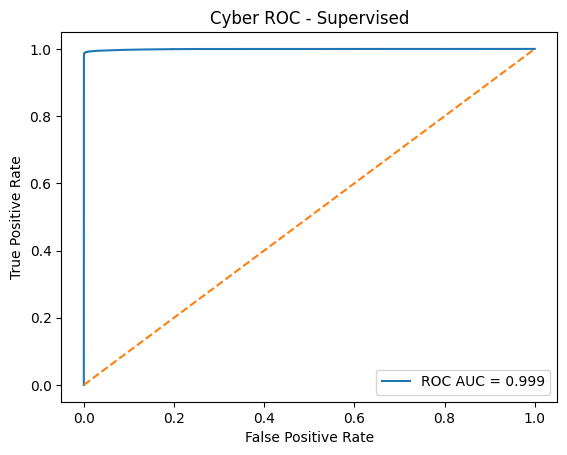

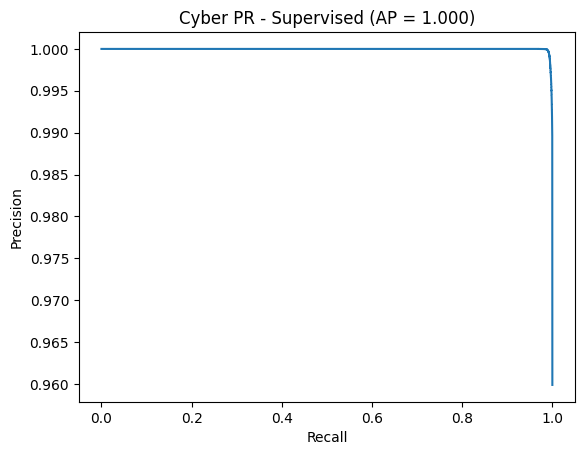

In [6]:
plot_roc_curve(y_test.values, y_test_prob, title='Cyber ROC - Supervised')
plot_pr_curve(y_test.values, y_test_prob, title='Cyber PR - Supervised')
